In [91]:
import random
from coup.agent import Player, TruthfulPlayer
import tqdm
import numpy as np
import pylab as plt

In [92]:
# Create a deck with 15 cards
roles = ['duke', 'assassin', 'captain', 'ambassador', 'contessa']

# Number of players
n_players = 5
n_cards_per_hand = 2
n_center_cards = 3

In [93]:
cards = random.sample(
    roles, n_players * n_cards_per_hand + n_center_cards, counts=[3] * 5
)

## Start w/ a super simple model

In [106]:
import random
from dataclasses import dataclass, fields
from typing import List, Dict, Set, Optional, Tuple
from enum import Enum
import inspect

@dataclass
class Character:
    DUKE: str = "Duke"
    ASSASSIN: str = "Assassin"
    CAPTAIN: str = "Captain"
    AMBASSADOR: str = "Ambassador"
    CONTESSA: str = "Contessa"

@dataclass
class Action:
    INCOME: str = "Income"
    FOREIGN_AID: str = "Foreign Aid"
    COUP: str = "Coup"
    TAX: str = "Tax"  # Duke
    ASSASSINATE: str = "Assassinate"  # Assassin
    STEAL: str = "Steal"  # Captain
    EXCHANGE: str = "Exchange"  # Ambassador

n_cards_per_hand = 2
n_center_cards = 3

class Arena:
    """
    """
    def __init__(self, n_players=3, lie_detector: list=None, player_types: list=None):
        """
        """
        self.cards = random.sample(
            list(Character.__dataclass_fields__.keys()), n_players * n_cards_per_hand + n_center_cards, counts=[3] * 5
        )

        if lie_detector is None:
            lie_detector = [0.2] * n_players
        if player_types is None:
            player_types = [Player] * n_players
            
        self.players = {}
        self.history = []
        self.player_order = []

        for i in range(n_players):
            player_id = random.randint(0, 10000000)
            idx = slice(i * n_cards_per_hand, i * n_cards_per_hand + 2)
            self.players[player_id] = player_types[i](self.cards[idx], player_id=player_id, lie_detector=lie_detector[i])
            self.player_order.append(player_id)

        self.deck = self.cards[-3:]

    def take_turn(self, player_id: int) -> None:
        """
        """
        # Get all available actions for a given player_id
        valid_actions = self.get_valid_actions(player_id)

        # TODO: Make better choice
        action = random.choice(valid_actions)

        # Response to counter
        counters = {}
        for player in self.players:
            if player == player_id or not self.players[player_id].active:
                continue
            # print (player)
            counter = self.players[player].challenge_action(action)
            if counter:
                counters[player] = counter
        # print (len(counters))
        # Challenge pick
        if len(counters) > 0:
            challenger_id = random.choice(list(counters.keys()))
            challenge = counters[challenger_id]
            challenge_response = self.players[player_id].response_to_challenge(
                challenge
            )
        else:
            challenger_id = None
            challenge_response = None
            challenge = None

        self.resolve_actions(player_id, action, challenge, challenger_id, challenge_response)
        
        player_states = [{"pid": k, "hand": self.players[k].hand.copy(), "revealed": self.players[k].revealed.copy(), "coins": self.players[k].coins} for k in self.players]
        self.history.append((player_id, action, challenge, challenger_id, challenge_response, *player_states))

    def get_valid_actions(self, player_id: int) -> List[Action]:
        """Get list of valid actions for the current player"""
        player = self.players[player_id]
        return player.get_valid_actions()

    def resolve_actions(self, player_id, action, challenge: Tuple=None, challenge_id: int=None, challenge_response: Tuple=None) -> None:
        """
        """
        # If a challenge is issues and no response is made, end turn
        if challenge and challenge[0] == 'challenge' and challenge_response is None:
            if action == Action.STEAL:
                # If someone attempts to steal from another player, that player can either claim to have 
                # the captain/ambassador, or challenge that the acting player has a captain.
                # XXX: Add branch for 
                if Character.CAPTAIN not in self.players[player_id].hand:
                    self.players[player_id].remove_influence()
            elif action == Action.ASSASSINATE:
                # If someone attempts to assassinate another player, 
                # that player can either claim to have the contessa, or challenge that the player actually has
                # the assassin
                if Character.CAPTAIN not in self.players[player_id].hand:
                    self.players[player_id].remove_influence()
            elif action == Action.EXCHANGE:
                if Character.AMBASSADOR not in self.players[player_id].hand:
                    self.players[player_id].remove_influence()
            elif action == Action.TAX:
                if Character.DUKE not in self.players[player_id].hand:
                    self.players[player_id].remove_influence()

        elif challenge and challenge[0] == 'block' and challenge_response is None:
            pass

        # If challenge is made and response is issued, resolve challenge
        elif challenge and challenge_response:
            if action == Action.FOREIGN_AID:
                if Character.DUKE not in self.players[challenge_id].hand:
                    self.players[challenge_id].remove_influence()
                    self.players[player_id].coins += 2
            elif action == Action.ASSASSINATE:
                # If someone attempts to assassinate another player, 
                # that player can either claim to have the contessa, or challenge that the player actually has
                # the assassin
                target_id = random.choice([
                    _player_id_ for _player_id_ in self.players 
                    if _player_id_ != player_id and self.players[_player_id_].active
                ])
                if Character.ASSASSIN not in self.players[challenge_id].hand:
                    self.players[challenge_id].remove_influence()
                    self.players[target_id].remove_influence()
            elif action == Action.STEAL:
                # If someone attempts to steal from another player, that player can either claim to have 
                # the captain/ambassador, or challenge that the acting player has a captain. If someone
                target_id = random.choice([
                    _player_id_ for _player_id_ in self.players 
                    if _player_id_ != player_id and self.players[_player_id_].active
                ])
                if Character.CAPTAIN not in self.players[challenge_id].hand or Character.AMBASSADOR not in self.players[challenge_id].hand:
                    self.players[challenge_id].remove_influence()
                    self.players[player_id].coins += min(2, self.players[target_id].coins)
                    self.players[target_id].coins -= min(2, self.players[target_id].coins)
                
        else:
            if action == Action.INCOME:
                self.players[player_id].coins += 1
            elif action == Action.FOREIGN_AID:
                self.players[player_id].coins += 2
            elif action == Action.TAX:
                self.players[player_id].coins += 3
            elif action == Action.STEAL:
                target_id = random.choice([
                    _player_id_ for _player_id_ in self.players 
                    if _player_id_ != player_id and self.players[_player_id_].active
                ])
                self.players[player_id].coins += min(2, self.players[target_id].coins)
                self.players[target_id].coins -= min(2, self.players[target_id].coins)
            elif action == Action.COUP:
                target_id = random.choice([
                    _player_id_ for _player_id_ in self.players 
                    if _player_id_ != player_id and self.players[_player_id_].active
                ])
                self.players[target_id].remove_influence()
                self.players[player_id].coins -= 7
            elif action == Action.ASSASSINATE:
                target_id = random.choice([
                    _player_id_ for _player_id_ in self.players 
                    if _player_id_ != player_id and self.players[_player_id_].active
                ])
                self.players[target_id].remove_influence()
                self.players[player_id].coins -= 3
            else:
                self.players[player_id].swap_hand(self.deck)

    def simulate_game(self):
        """
        """
        is_game_over = False
        nturns = 0
        while not is_game_over:
            for player_id in self.players:
                is_game_over = self.is_game_over()
                if self.players[player_id].active and not is_game_over:
                    self.take_turn(player_id)
                    nturns += 1
        #winner = [
        #    self.players[player_id].lie_detector 
        #    for player_id in self.players
        #    if self.players[player_id].active
        #]
        winner = [
            self.players[player_id]._player_archetype_ 
            for player_id in self.players
            if self.players[player_id].active
        ]
        return nturns, winner[0]
                    
    def is_game_over(self):
        """
        """
        return sum([self.players[player_id].active for player_id in self.players]) <= 1

In [107]:
player = TruthfulPlayer([1, 2], player_id=1)

In [102]:
num_turns = {}
winners = {}
for n_players in range(2, 7):
    num_turns[n_players] = []
    winners[n_players] = []
    player_types = [Player] * (n_players - 1) + [TruthfulPlayer]
    for i in tqdm.tqdm(range(50000)):
        #lie_detector = np.linspace(0, 1.0, n_players)
        #np.random.shuffle(lie_detector)
        #arena = Arena(n_players=n_players, lie_detector=lie_detector)
        random.shuffle(player_types)
        arena = Arena(n_players=n_players, player_types=player_types, lie_detector=[1.0] * n_players)
        for k in arena.players:
            if arena.players[k]._player_archetype_ == 'Truthful':
                arena.players[k].lie_detector = 0.0
        nturns, winner = arena.simulate_game()
        num_turns[n_players].append(nturns)
        winners[n_players].append(winner)

100%|███████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:20<00:00, 2475.51it/s]


In [111]:
n_players = 2
player_types = [Player] + [TruthfulPlayer]
random.shuffle(player_types)
arena = Arena(n_players=n_players, player_types=player_types, lie_detector=[1.0] * n_players)
for k in arena.players:
    if arena.players[k]._player_archetype_ == 'Truthful':
        arena.players[k].lie_detector = 0.0
nturns, winner = arena.simulate_game()

In [112]:
for k in arena.players:
    print (k, arena.players[k]._player_archetype_, arena.players[k].hand, arena.players[k].revealed)

7736749 Truthful [] ['CAPTAIN', 'AMBASSADOR']
6708945 Default ['CAPTAIN', 'CONTESSA'] []


In [113]:
arena.history

[(7736749,
  'Income',
  None,
  None,
  None,
  {'pid': 7736749,
   'hand': ['AMBASSADOR', 'CAPTAIN'],
   'revealed': [],
   'coins': 3},
  {'pid': 6708945,
   'hand': ['CONTESSA', 'CAPTAIN'],
   'revealed': [],
   'coins': 2}),
 (6708945,
  'Income',
  None,
  None,
  None,
  {'pid': 7736749,
   'hand': ['AMBASSADOR', 'CAPTAIN'],
   'revealed': [],
   'coins': 3},
  {'pid': 6708945,
   'hand': ['CONTESSA', 'CAPTAIN'],
   'revealed': [],
   'coins': 3}),
 (7736749,
  'Income',
  None,
  None,
  None,
  {'pid': 7736749,
   'hand': ['AMBASSADOR', 'CAPTAIN'],
   'revealed': [],
   'coins': 4},
  {'pid': 6708945,
   'hand': ['CONTESSA', 'CAPTAIN'],
   'revealed': [],
   'coins': 3}),
 (6708945,
  'Exchange',
  None,
  None,
  None,
  {'pid': 7736749,
   'hand': ['AMBASSADOR', 'CAPTAIN'],
   'revealed': [],
   'coins': 4},
  {'pid': 6708945,
   'hand': ['CAPTAIN', 'CONTESSA'],
   'revealed': [],
   'coins': 3}),
 (7736749,
  'Income',
  None,
  None,
  None,
  {'pid': 7736749,
   'hand': [

In [86]:
for i in range(2, 7):
    print (i, winners[i].count('Truthful'), winners[i].count('Default'))

2 0 50000
3 50000 0
4 50000 0
5 50000 0
6 50000 0


6.84242
9.7526
12.92098
16.17214
19.4624


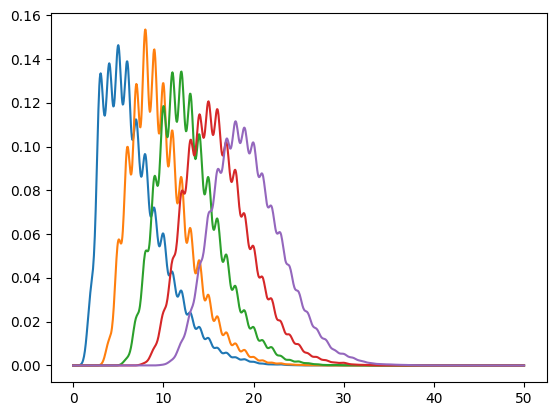

In [77]:
from scipy import stats
plt.figure()
positions = np.linspace(0, 50, 1000)
for k in num_turns:
    #plt.hist(num_turns[k], histtype='step', density=True)
    kernel = stats.gaussian_kde(num_turns[k])
    plt.plot(positions, kernel(positions))
    print (np.mean(num_turns[k]))

#plt.xlim([0, 60])

In [81]:
for k in arena.players:
    print (k, arena.players[k]._player_archetype_, arena.players[k].hand, arena.players[k].revealed)

2189987 Default [] ['CAPTAIN', 'AMBASSADOR']
79709 Default [] ['CONTESSA', 'CAPTAIN']
9287634 Default [] ['ASSASSIN', 'AMBASSADOR']
2443312 Default [] ['ASSASSIN', 'DUKE']
7715849 Default [] ['DUKE', 'CAPTAIN']
9058998 Truthful ['AMBASSADOR'] ['DUKE']


# LSTM

In [64]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
from torch.utils.data import Dataset, DataLoader

class SimpleDataset(Dataset):
    def __init__(self, seq_length=10, num_samples=1000):
        # Generate simple sequences where next number is sum of previous two
        self.sequences = []
        self.targets = []
        
        for _ in range(num_samples):
            seq = [np.random.rand(), np.random.rand()]
            for i in range(seq_length - 2):
                seq.append(seq[-1] + seq[-2])
            
            self.sequences.append(seq[:-1])
            self.targets.append(seq[-1])
            
        self.sequences = torch.FloatTensor(self.sequences)
        self.targets = torch.FloatTensor(self.targets)
        
    def __len__(self):
        return len(self.sequences)
        
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

class LSTMPredictor(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMPredictor, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        lstm_out, _ = self.lstm(x.unsqueeze(-1), (h0, c0))
        
        # Get output from last time step
        output = self.fc(lstm_out[:, -1, :])
        return output.squeeze()

def train_model(model, train_loader, num_epochs=10, learning_rate=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        total_loss = 0
        
        for batch_sequences, batch_targets in train_loader:
            batch_sequences = batch_sequences.to(device)
            batch_targets = batch_targets.to(device)
            
            # Forward pass
            outputs = model(batch_sequences)
            loss = criterion(outputs, batch_targets)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(train_loader)
        #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

def main():
    # Create dataset and dataloader
    dataset = SimpleDataset()
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True)
    
    # Initialize model
    model = LSTMPredictor()
    
    # Train model
    train_model(model, train_loader, num_epochs=200)
    
    # Example prediction
    model.eval()
    with torch.no_grad():
        sample_seq = dataset.sequences[0].unsqueeze(0)
        prediction = model(sample_seq)
        actual = dataset.targets[0]
        print(f'Prediction: {prediction.item():.4f}')
        print(f'Actual: {actual.item():.4f}')

    return dataset, model

In [65]:
model = main()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.34it/s]

Prediction: 26.8539
Actual: 26.5534


In [67]:
dataset, _model = model

In [68]:
sample_seq = dataset.sequences[0].unsqueeze(0)
prediction = _model(sample_seq)
actual = dataset.targets[0]